#### 1. 패키지 로딩하기

In [5]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", 
#                            filename = "attention.py")

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from attention import AttentionLayer
from summa.summarizer import summarize
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate

import os
import re
import nltk
import requests
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt

#### 2. 데이터 불러오기

In [2]:
data_path = os.getenv("HOME") + "/aiffel/news_summarization/data/news_summary_more.csv" # 데이터 경로 지정
data      = pd.read_csv(data_path, encoding = "iso-8859-1")                             # 데이터 불러오기

## 추상적 요약 해보기

#### 3. 데이터 전처리

* 3_1. 랜덤으로 샘플 5개를 출력하기

In [3]:
data.sample(5)

,headlines,text
27665,"PM fitness video shot by PMO staffer, no money...",After Congress leader Shashi Tharoor tweeted t...
10506,French Prez's European army proposal 'very ins...,US President Donald Trump has called French Pr...
92025,Man returns home after 7-year cycling trip aro...,"A 35-year-old man from England, Leigh Timmis, ..."
18920,Myanmar army apologises for fake pics in Rohin...,The Myanmar military on Monday issued an apolo...
34697,Sunil Grover to feature in Salman Khan's 'Bhar...,"According to reports, comedian Sunil Grover wi..."


* 3_2. 데이터 전체 길이 보기

In [4]:
print("전체 데이터 갯수 :", len(data))

전체 데이터 갯수 : 98401


* 3_3. 데이터 칼럼 보기

In [5]:
data.columns # 노드와 비교하자면 headlines은 Summary(요약된 데이터)로 볼 수 있고, text는 Text(본문)로 볼 수 있다.

Index(['headlines', 'text'], dtype='object')

* 3_4. 중복된 데이터 파악하기

In [6]:
print("headline의 데이터 갯수 :",               len(data["headlines"]))
print("headlines의 중복 데이터 갯수 :",         len(data["headlines"]) - data["headlines"].nunique())
print("headlines의 중복을 제외한 데이터 갯수 :", data["headlines"].nunique())
print("\ntext의 데이터 갯수 :",                 len(data["text"]))
print("text의 중복 데이터 갯수 :",              len(data["text"]) - data["text"].nunique())
print("text의 중복을 제외한 데이터 갯수 :",      data["text"].nunique())

headline의 데이터 갯수 : 98401
headlines의 중복 데이터 갯수 : 121
headlines의 중복을 제외한 데이터 갯수 : 98280

text의 데이터 갯수 : 98401
text의 중복 데이터 갯수 : 41
text의 중복을 제외한 데이터 갯수 : 98360


* 3_5. 중복된 데이터 제거하기

In [7]:
# 뉴스가 제목은 중복될 수 있어도 내용이 중복되는 것은 없을 거라 생각이 되므로 text의 중복 데이터만 지우기로 했다.
data.drop_duplicates(subset = ["text"], inplace = True)

print("중복제거 후 데이터 갯수 :", len(data)) # 위의 text의 중복을 제외한 데이터 갯수와 일치하면 성공

중복제거 후 데이터 갯수 : 98360


* 3_6. 결측치 확인하기

In [8]:
data.isnull().sum() # 없음

headlines    0
text         0
dtype: int64

* 3_7. 데이터 정규화 사전 준비하기

In [9]:
# 사전은 노드의 코드를 가져다씀.
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", 
                "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", 
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", 
                "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print("정규화 사전의 수:", len(contractions))

정규화 사전의 수: 120


* 3_8. 불용어(stopword) 사전 준비하기

In [10]:
print("불용어 갯수 :", len(stopwords.words("english")))
print(stopwords.words("english"))

불용어 갯수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

* 3_9. 데이터 전처리를 해주는 함수 만들기

In [11]:
def preprocess_data(sentence, remove_stopwords = True): # sentence = 받을 문장, remove_stopwords = 불용어 제거 여부
    sentence = sentence.lower()                         # 텍스트 소문자로 변환
    sentence = BeautifulSoup(sentence, "lxml").text     # <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r"\([^)]*\)", "", sentence)       # 괄호로 닫힌 문자열 제거,  ex) my husband (and myself!) for => my husband for
    sentence = re.sub('""', "", sentence)               # 쌍따옴표("") 제거
    sentence = " ".join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"s\b", "", sentence)             # 소유격 제거, ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)       # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[m]{2,}", "mm", sentence)        # m이 3개 이상이면 2개로 변경, ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text용)
    if remove_stopwords:
        tokens = " ".join(word for word in sentence.split() if not word in stopwords.words("english") if len(word) > 1)
    # 불용어 미제거 (headlines용)
    else:
        tokens = " ".join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

In [12]:
# 함수가 잘 만들어졌는지 테스트해보기
temp_text     = "Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father."
temp_headline = "Great way to start (or finish) the day!!!"

print(preprocess_data(temp_text,     remove_stopwords = True))
print(preprocess_data(temp_headline, remove_stopwords = False))

everything bought wa great infact ordered twice third ordered wasfor mother father
great way to start the day


* 3_10. 데이터 전처리 함수를 이용하여 데이터 전처리하기

In [13]:
preprocess_text = []

# 전체 text 데이터에 대한 전처리 : 약 10분정도 소요됨.
for t in data["text"]:
    preprocess_text.append(preprocess_data(t, remove_stopwords = True))
    
# 전처리 후 5개만 출력해보기
preprocess_text[:5]

['saurav kant alumnu upgrad iiit pg program machine learning artificial intelligence wa sr system engineer infosy almost year work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning ha powered lakh career',
 'kunal shah credit card bill payment platform cred gave user chance win free food swiggy one year pranav kaushik delhi techie bagged thi reward spending cred coin user get one cred coin per rupee bill paid used avail reward brand like ixigo bookmyshow ubereat cult fit',
 'new zealand defeated india wicket fourth odi hamilton thursday win first match five match odi serie india lost international match rohit sharma captaincy consecutive victorie dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customer enjoy tax benefit premium paid save taxe plan provide life cover age year also customer option insure critical illnesse disab

In [14]:
preprocess_headlines = []

# 전체 headline 데이터에 대한 전처리 : 약 3분정도 소요됨.
for h in data["headlines"]:
    preprocess_headlines.append(preprocess_data(h, remove_stopwords = False))
    
# 전처리 후 5개만 출력해보기
preprocess_headlines[:5]

['upgrad learner switche to career in ml al with salary hike',
 'delhi techie win free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan help customer save tax',
 'have known hirani for yr what if metoo claim are not true sonam']

* 3_11. 데이터 전처리 후 결측치 확인하기

In [15]:
data["text"]      = preprocess_text
data["headlines"] = preprocess_headlines

# 빈 값을 Null 값으로 변환
data.replace("", np.nan, inplace = True)

# Null 값 출력하기
data.isnull().sum() # 없음

headlines    0
text         0
dtype: int64

#### 4. 훈련 데이터, 테스트 데이터 나누기

* 4_1 데이터 길이 분포 확인하기

In [16]:
text_len     = [len(t.split()) for t in data["text"]]
headline_len = [len(h.split()) for h in data["headlines"]]

print(f"text의 최소 길이 : {np.min(text_len)}")
print(f"text의 최대 길이 : {np.max(text_len)}")
print(f"text의 평균 길이 : {np.mean(text_len)}")
print(f"text의 평균 표준편차 : {np.std(text_len)}")
print(f"headline의 최소 길이 : {np.min(headline_len)}")
print(f"headline의 최대 길이 : {np.max(headline_len)}")
print(f"headline의 평균 길이 : {np.mean(headline_len)}")
print(f"headline의 표준편차 길이 : {np.std(headline_len)}")

text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 36.46954046360309
text의 평균 표준편차 : 3.8038244373301513
headline의 최소 길이 : 1
headline의 최대 길이 : 16
headline의 평균 길이 : 9.168289955266369
headline의 표준편차 길이 : 1.3843343607346648


* 4_2. 데이터 길이 분포의 상자그림

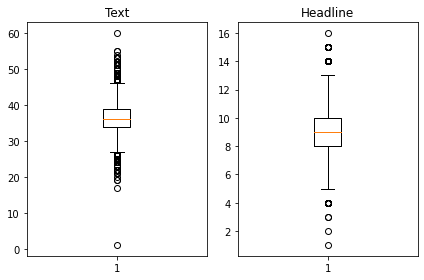

In [17]:
plt.subplot(1, 2, 1)      # 그림 위치 지정
plt.boxplot(text_len)     # 박스그림 그리기
plt.title("Text")         # 그래프 제목 지정

plt.subplot(1, 2, 2)      # 그림 위치 지정
plt.boxplot(headline_len) # 박스그림 그리기
plt.title("Headline")     # 그래프 제목 지정

plt.tight_layout()        # 그림 간 패딩 조정
plt.show()                # 그림을 보여주기

* 4_3. 데이터 길이 분포의 히스토그램

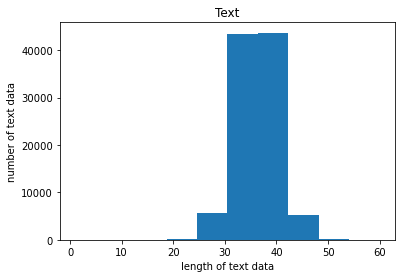

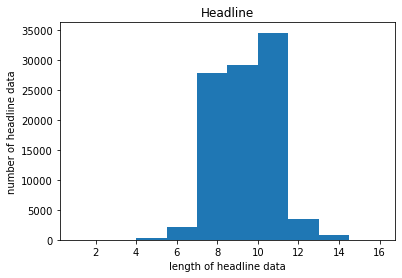

In [18]:
plt.title("Text")                     # 제목 지정
plt.hist(text_len)                    # 히스토그램 그리기
plt.xlabel("length of text data")     # X축 이름 지정
plt.ylabel("number of text data")     # Y축 이름 지정
plt.show()                            # 그림을 보여주기

plt.title("Headline")                 # 제목 지정
plt.hist(headline_len)                # 히스토그램 그리기
plt.xlabel("length of headline data") # X축 이름 지정
plt.ylabel("number of headline data") # Y축 이름 지정
plt.show()                            # 그림을 보여주기

* 4_4. 데이터와 데이터의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수 만들기

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for l in nested_list:
        if(len(l.split()) <= max_len):
            cnt = cnt + 1
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s" % (max_len, (cnt / len(nested_list))))

* 4_5. 알맞은 데이터의 길이 구하기

In [20]:
text_max     = 45
headline_max = 14

below_threshold_len(text_max,     data["text"])
below_threshold_len(headline_max, data["headlines"])

전체 샘플 중 길이가 45 이하인 샘플의 비율 : 0.9917852785685238
전체 샘플 중 길이가 14 이하인 샘플의 비율 : 0.9998678324522163


* 4_6. 지정한 데이터 길이보다 긴 데이터 잘라내기

In [21]:
data = data[data["text"].apply(lambda x : len(x.split()) <= text_max)]
data = data[data["headlines"].apply(lambda x : len(x.split()) <= headline_max)]
print("전체 샘플수 :", len(data))

전체 샘플수 : 97539


* 4_7. 시작 토큰과 종료 토큰 추가하기

In [22]:
data["decoder_input"]  = data["headlines"].apply(lambda x : "sostoken " + x) # 시작 토큰 추가하기
data["decoder_target"] = data["headlines"].apply(lambda x : x + " eostoken") # 종료 토큰 추가하기
data.head()                                                                  # 잘 붙었는지 확인하기

,headlines,text,decoder_input,decoder_target
0,upgrad learner switche to career in ml al with...,saurav kant alumnu upgrad iiit pg program mach...,sostoken upgrad learner switche to career in m...,upgrad learner switche to career in ml al with...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wicket fourth odi h...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan help customer ...,aegon life iterm insurance plan customer enjoy...,sostoken aegon life iterm insurance plan help ...,aegon life iterm insurance plan help customer ...
4,have known hirani for yr what if metoo claim a...,speaking sexual harassment allegation rajkumar...,sostoken have known hirani for yr what if meto...,have known hirani for yr what if metoo claim a...
5,rahat fateh ali khan denie getting notice for ...,pakistani singer rahat fateh ali khan ha denie...,sostoken rahat fateh ali khan denie getting no...,rahat fateh ali khan denie getting notice for ...


In [23]:
encoder_input  = np.array(data["text"])           # 인코더 입력
decoder_input  = np.array(data["decoder_input"])  # 디코더 입력
decoder_target = np.array(data["decoder_target"]) # 디코더 레이블

* 4_8. 훈련데이터와 테스트 데이터 나누기

In [24]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[81889 52805 78786 ... 44769 13308 65649]


In [25]:
# 위 정수 시퀀스를 이용해 데이터 순서를 정의해주면 잘 섞인 데이터가 된다.
encoder_input  = encoder_input[indices]
decoder_input  = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
# 전체 데이터의 길이에 0.2를 곱해서 8:2 비율로 훈련 데이터와 테스트 데이터를 분리한다.
n_of_val = int(len(encoder_input) * 0.2)
print("테스트 데이터의 갯수 :", n_of_val)

테스트 데이터의 갯수 : 19507


In [27]:
encoder_input_train  = encoder_input[:-n_of_val]
decoder_input_train  = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test   = encoder_input[-n_of_val:]
decoder_input_test   = decoder_input[-n_of_val:]
decoder_target_test  = decoder_target[-n_of_val:]

print("훈련 데이터의 갯수 :",   len(encoder_input_train))
print("훈련 레이블의 갯수 :",   len(decoder_input_train))
print("테스트 데이터의 갯수 :", len(encoder_input_test))
print("테스트 레이블의 갯수 :", len(decoder_input_test))

훈련 데이터의 갯수 : 78032
훈련 레이블의 갯수 : 78032
테스트 데이터의 갯수 : 19507
테스트 레이블의 갯수 : 19507


#### 5. 정수 인코딩 하기

* 5_1. 훈련 데이터 단어 집합 만들기

In [28]:
# keras의 토크나이저를 이용한다.
src_tokenizer = Tokenizer()                     # 토크나이저 생성
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [29]:
# 훈련 데이터의 단어 집합 크기를 정하기 위해 단어 수 분포 확인하기
threshold  = 7
total_cnt  = len(src_tokenizer.word_index) # 단어의 수
rare_cnt   = 0                             # 등장 빈도수가 threshold보다 작은 단어의 갯수를 카운트
total_freq = 0                             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq  = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold): # 단어의 등장 빈도수가 threshold보다 작으면
        rare_cnt  = rare_cnt  + 1
        rare_freq = rare_freq + value
        
print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 이하인 회귀 단어의 수 : %s" % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : %s" % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 62365
등장 빈도가 6번 이하인 회귀 단어의 수 : 42675
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : 19690
단어 집합에서 희귀 단어의 비율 : 68.42780405676261
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 3.0219591542613946


In [30]:
# 등장 빈도가 7미만인 단어의 단어 사전 집합 차지율은 68% 정도이고,
# 등장 빈도가 7미만인 단어의 훈련 데이터 차지율은 3% 정도이다.
# 이 단어들을 제외하고 단어 사전 집합의 갯수는 19614로 예상하고 있다.
# 단어 사전의 크기는 19000으로 하면 될 듯 하다.
src_vocab     = 19000                            # 단어 사전 크기 지정
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 지정
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 재생성

In [31]:
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test  = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행됬는지 출력해보기
print(encoder_input_train[:3])

[[372, 1298, 875, 1183, 704, 1, 680, 23, 257, 213, 963, 2340, 15, 1799, 260, 1141, 2, 1504, 773, 4350, 5437, 1437, 596, 372, 7, 446, 549, 1926, 11008, 2466, 7151, 1504], [2233, 1785, 60, 1742, 1039, 537, 176, 9124, 4071, 97, 2, 4, 864, 18381, 4071, 479, 248, 94, 2552, 24, 4, 5, 495, 1562, 2, 18381, 13720, 1742, 237, 3, 5054, 2289, 3, 1064, 495, 2495, 489], [45, 1198, 176, 1198, 360, 824, 527, 3048, 92, 10, 635, 3, 588, 4487, 15659, 1343, 946, 276, 2140, 830, 7, 209, 738, 2, 392, 126, 116]]


In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold  = 7
total_cnt  = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt   = 0                             # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                             # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq  = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수 : %s" % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s" % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율 :", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 25928
등장 빈도가 6번 이하인 희귀 단어의 수 : 17478
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8450
단어 집합에서 희귀 단어의 비율 : 67.40975007713669
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : 4.5934574020198555


In [34]:

8. 인퍼런스 모델 구현하기 (실제 동작할 모델)
In [40]:
￼
src_index_to_word = src_tokenizer.index_word # 본문     단어 집합에서 정수 -> 단어로 얻음
tar_word_to_index = tar_tokenizer.word_index # 헤드라인 단어 집합에서 단어 -> 정수로 얻음
tar_index_to_word = tar_tokenizer.index_word # 헤드라인 단어 집합에서 정수 -> 단어로 얻음
In [42]:
￼
# 인코더 설계
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])
​
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape = (hidden_size,))
decoder_state_input_c = Input(shape = (hidden_size,))
dec_emb2              = dec_emb_layer(decoder_inputs)
​
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])
​
# 어텐션 함수
decoder_hidden_state_input    = Input(shape = (text_max, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat            = Concatenate(axis = -1, name = "concat")([decoder_outputs2, attn_out_inf])
​
# 디코더의 출력층# 등장 빈도가 7미만인 단어의 단어 사전 집합 차지율은 67% 정도이고,
# 등장 빈도가 7미만인 단어의 훈련 데이터 차지율은 4.6% 정도이다.
# 이 단어들을 제외하고 단어 사전 집합의 갯수는 8448로 예상하고 있다.
# 단어 사전의 크기는 8000으로 하면 될 듯 하다.
tar_vocab     = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train  = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test   = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test  = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 진행됬는지 출력해보기
print("input")
print(decoder_input_train[:5])
print("target")
print(decoder_target_train[:5])

input
[[1, 362, 319, 225, 1021, 62, 138, 606, 702, 3, 346], [1, 746, 671, 953, 176, 3, 7339, 13, 228, 1473, 6176], [1, 161, 24, 807, 125, 443, 472, 34, 366, 433, 4303], [1, 28, 1028, 5, 912, 6, 195, 363, 4749, 4], [1, 3944, 285, 32, 716, 1229, 94]]
target
[[362, 319, 225, 1021, 62, 138, 606, 702, 3, 346, 2], [746, 671, 953, 176, 3, 7339, 13, 228, 1473, 6176, 2], [161, 24, 807, 125, 443, 472, 34, 366, 433, 4303, 2], [28, 1028, 5, 912, 6, 195, 363, 4749, 4, 2], [3944, 285, 32, 716, 1229, 94, 2]]


In [35]:
# 결측치 확인하기

# 주의 
# decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고,
# 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않는다. 
# 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나오므로 길이가 1인 것을 제거할 것이다.

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test  = [index for index, sentence in enumerate(decoder_input_test)  if len(sentence) == 1]

print("삭제할 훈련 데이터의 갯수 :", len(drop_train))
print("삭제할 테스트 데이터의 갯수 :", len(drop_test))

encoder_input_train  = np.delete(encoder_input_train,  drop_train, axis = 0)
decoder_input_train  = np.delete(decoder_input_train,  drop_train, axis = 0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis = 0)

encoder_input_test   = np.delete(encoder_input_test,  drop_test, axis = 0)
decoder_input_test   = np.delete(decoder_input_test,  drop_test, axis = 0)
decoder_target_test  = np.delete(decoder_target_test, drop_test, axis = 0)

print("훈련 데이터의 갯수 :",   len(encoder_input_train))
print("훈련 레이블의 갯수 :",   len(decoder_input_train))
print("테스트 데이터의 갯수 :", len(encoder_input_test))
print("테스트 레이블의 갯수 :", len(decoder_input_test))

삭제할 훈련 데이터의 갯수 : 0
삭제할 테스트 데이터의 갯수 : 0
훈련 데이터의 갯수 : 78032
훈련 레이블의 갯수 : 78032
테스트 데이터의 갯수 : 19507
테스트 레이블의 갯수 : 19507


* 5_2. 패딩하기

In [36]:
encoder_input_train  = pad_sequences(encoder_input_train,  maxlen = text_max,     padding = "post")
encoder_input_test   = pad_sequences(encoder_input_test,   maxlen = text_max,     padding = "post")
decoder_input_train  = pad_sequences(decoder_input_train,  maxlen = headline_max, padding = "post")
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max, padding = "post")
decoder_input_test   = pad_sequences(decoder_input_test,   maxlen = headline_max, padding = "post")
decoder_target_test  = pad_sequences(decoder_target_test,  maxlen = headline_max, padding = "post")

#### 6. 모델 설계하기

In [37]:
# 인코더 설계 시작
# hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다. 
# 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 갯수라고 이해하면 된다. 
# 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다.
embedding_dim = 128
hidden_size   = 256

# 인코더
encoder_inputs = Input(shape = (text_max,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1                       = LSTM(hidden_size, 
                                           return_sequences  = True, 
                                           return_state      = True, 
                                           dropout           = 0.4, 
                                           recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size,
                     return_sequences  = True,
                     return_state     = True,
                     dropout           = 0.4,
                     recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size,
                     return_sequences  = True,
                     return_state      = True,
                     dropout           = 0.4,
                     recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


# 디코더 설계
decoder_inputs = Input(shape = (None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb       = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm          = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 어텐션

# 디코더의 출력층
decoder_softmax_layer   = Dense(tar_vocab, activation = "softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 어텐션 층 (어텐션 함수)
attn_layer = AttentionLayer(name = "attention_layer")

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name = "concat_layer")([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer   = Dense(tar_vocab, activation = "softmax")
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 7. 모델 훈련하기

In [38]:
model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy")
# val_loss를 모니터하는데 mode는 min이고, patience를 2로 줘서 최저점을 찍고 loss값이 다시 높아지는게 2번 나타나면 멈추겠다.
es      = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 2)
history = model.fit(x               = [encoder_input_train, decoder_input_train],
                    y               = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size      = 256,
                    callbacks       = [es],
                    epochs          = 50)

Epoch 1/50
305/305 [==============================] - 102s 334ms/step - loss: 4.7136 - val_loss: 4.3595
Epoch 2/50
305/305 [==============================] - 102s 333ms/step - loss: 4.2133 - val_loss: 3.9951
Epoch 3/50
305/305 [==============================] - 101s 333ms/step - loss: 3.8958 - val_loss: 3.7584
Epoch 4/50
305/305 [==============================] - 102s 333ms/step - loss: 3.6756 - val_loss: 3.6017
Epoch 5/50
305/305 [==============================] - 102s 333ms/step - loss: 3.5047 - val_loss: 3.4831
Epoch 6/50
305/305 [==============================] - 102s 334ms/step - loss: 3.3626 - val_loss: 3.3795
Epoch 7/50
305/305 [==============================] - 102s 334ms/step - loss: 3.2381 - val_loss: 3.3038
Epoch 8/50
305/305 [==============================] - 102s 334ms/step - loss: 3.1317 - val_loss: 3.2399
Epoch 9/50
305/305 [==============================] - 102s 334ms/step - loss: 3.0384 - val_loss: 3.1853
Epoch 10/50
305/305 [==============================] - 102s 333m

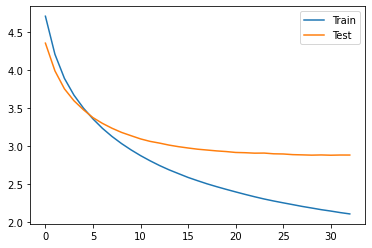

In [39]:
# 모델이 훈련했던 loss와 val_loss를 시각화하기
plt.plot(history.history["loss"],     label = "Train") # loss의 선 그래프 그리기
plt.plot(history.history["val_loss"], label = "Test")  # val_loss의 선 그래프 그리기
plt.legend()                                           # 범주 만들어주기
plt.show()                                             # 그래프 출력하기

#### 8. 인퍼런스 모델 구현하기 (실제 동작할 모델)

In [40]:
src_index_to_word = src_tokenizer.index_word # 본문     단어 집합에서 정수 -> 단어로 얻음
tar_word_to_index = tar_tokenizer.word_index # 헤드라인 단어 집합에서 단어 -> 정수로 얻음
tar_index_to_word = tar_tokenizer.index_word # 헤드라인 단어 집합에서 정수 -> 단어로 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape = (hidden_size,))
decoder_state_input_c = Input(shape = (hidden_size,))
dec_emb2              = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input    = Input(shape = (text_max, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat            = Concatenate(axis = -1, name = "concat")([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs]   + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c], 
    [decoder_outputs2] + [state_h2, state_c2])

* 8_1. 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수만들기

In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c  = encoder_model.predict(input_seq)
    
    # <SOS>에 해당하는 토큰 생성
    target_seq       = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index["sostoken"]
    
    stop_condition   = False
    decoded_sentence = ""
    
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token       = tar_index_to_word[sampled_token_index]
        
        if(sampled_token != "eostoken"):
            decoded_sentence += " " + sampled_token
            
        # <eos>에 도달하거나 최대 길이를 넘으면 중단
        if(sampled_token == "eostoken" or len(decoded_sentence.split()) >= (headline_max - 1)):
            stop_condition = True
            
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트 합니다.
        e_h, e_c = h, c
        
    return decoded_sentence

#### 9. 모델 테스트하기

In [51]:
# 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다. 
# 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들것이다. 
# 함수를 만들 때, text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 
# headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외시키도록 만들것이다.

# 본문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ""
    for i in input_seq:
        if(i != 0):
            temp = temp + src_index_to_word[i] + " "
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp = ""
    for i in input_seq:
        if((i != 0 and i != tar_word_to_index["sostoken"]) and i != tar_word_to_index["eostoken"]):
            temp = temp + tar_index_to_word[i] + " "
    return temp

In [52]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보기.
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 헤드라인 :", seq2headline(decoder_input_test[i]))
    print("예측 헤드라인 :", decode_sequence(encoder_input_test[i].reshape(1, text_max)))
    print("\n")

원문 : john abraham ha replaced sushant singh rajput lead role upcoming thriller romeo akbar walter john took twitter share day shoot robbie directorial commence june filmmaker earlier claimed mutually parted way sushant due circumstance 
실제 헤드라인 : john replace sushant in upcoming film romeo akbar 
예측 헤드라인 :  john abraham to star in tv show report


원문 : uk duches kate middleton uncle gary ha fined lakh hitting hi wife slapped argument last month year old wa also given month community order including rehabilitation session wa spared jail term assault apologised said wa deeply ashamed hi behaviour 
실제 헤드라인 : uk kate uncle fined after hitting wife 
예측 헤드라인 :  uk prince fined for assaulting girlfriend


원문 : ambani family friday hosted isha ambani anand piramal second wedding reception mumbai jio garden singer composer ar rahman performed first picture open air reception surfaced online piramal family hosted couple first reception december newlywed crore sea facing marital home mumbai 
실제 헤

예측 헤드라인 :  jadeja overtake ashwin to be pacer in icc odi ranking


원문 : national disaster response force deployed sunday morning rescue people stranded state run bu waterlogged mysuru road bengaluru patient evacuated flooded government hospital heavy rainfall saturday night uprooted tree two major flooded several localitie waterlogged 
실제 헤드라인 : over people stuck in luru bu flooded hospital rescued 
예측 헤드라인 :  heavy rainfall stuck in rain in mumbai


원문 : ministry corporate affair planning collect know customer detail companie chartered accountant cost accountant company secretarie exercise would help form list companie professional secretary sriniva said ministry earlier carried kyc initiative company director prevent illicit flow fund 
실제 헤드라인 : companie ca may have to submit kyc detail to government 
예측 헤드라인 :  govt ask govt to send money to data breach


원문 : kotak mahindra bank net profit december quarter rose year year crore profit crore period last year lender net interest incom

예측 헤드라인 :  mithali raj become st woman to slam odi for women


원문 : infosy co founder narayana murthy ha said keeping quiet may make seem gentle good potential wound company chose speak question wish see thi company flourish added earlier former infosy board member urged murthy wound infosy hi action 
실제 헤드라인 : keeping quiet would have infosy murthy 
예측 헤드라인 :  my life would be like infosy infosy murthy


원문 : government draft law criminalising instant triple talaq allow man divorce hi wife saying word talaq thrice propose three year jail term fine offender offence non bailable right maintenance child custody accorded victim divorce report said 
실제 헤드라인 : draft law on triple talaq propose yr jail for husband 
예측 헤드라인 :  what are the law centre to sc on triple talaq case


원문 : india muslim president ali khan ha announced would give lakh cash publicly destroy poster mohammad ali jinnah people like khan added pakistan never displayed photo mahatma gandhi freedom fighter indian university

## 추출적 요약 해보기

#### 10. summarize 사용해보기

In [7]:
text = requests.get("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv").text

In [8]:
len(text)

41315359

In [9]:
print(text[:1000])

headlines,text
upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Ham

In [14]:
data

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [46]:
# Summa의 summarize()의 인자로 사용되는 값.
# text (str) : 요약할 테스트.
# ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
# words (int or None, optional) – 출력에 포함할 단어 수.
# 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
# split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환
print('Summary:')
print(summarize(str(data["text"]), ratio = 0.05, split = True))

Summary:
[]


#### 11. 회고록

In [ ]:
# 추상적 요약에서 정규화를 하는데, 정규표현식이 이해가 잘 되지 않았다.
# 데이터 분포를 봤을 때 먼가 정규분포인듯 해서 분포를 확인 할 때 표준편차 * 3를 이용했다. (만약 정규분포라면 그 안의 데이터가 99% 들어있을테니까)
# 실습에 사용한 데이터는 결측치가 처음에도 없었고, 전처리를 하면서도 생기지 않아서 좋았다.
# 모델은 노드를 그대로 쓰면서 어떻게 작성하는지 한번 작성하고 보는데 만족을 했다. 학습을 하는데 30분 이상이 걸릴 줄은 몰랐다.
# 헤드라인을 예측은 하는데 영어로 써있어서 잘 예측했는지 판단은 못하겠지만, 내가 만들고 학습시킨 모델이 무언가 결과물을 만들었다는게 신기했다.

# 추출적 요약을 하는데 처음에는 불러온 데이터프레임을 어떻게 쓰려고 노력을 했지만 실패했다. 아무리 해도 string이 되지 않았다.
# 결국 노드에서 사용한 것처럼 text를 불러와서 모델을 돌렸다.
# 그리고 모델을 돌리는데 아무리 해도 멈추질 않는다.
# 그래서 그냥 str(data["text"])로 해서 돌렸는데 빈 스트링이 나온다..